In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

In [2]:
fgsm_epsilons = [0, .05, .1, .15, .2, .25, .3]
pgd_epsilons = [0, 5/255, 15/255, 25/255, 35/255]
# Parameters given in Assignment
epsilon_param = 25/255
alpha_param = 10/255
max_iter = 15
pretrained_model = "data/lenet_mnist_model.pth"
num_test_samples = 1000
# Set random seed for reproducibility
torch.manual_seed(42)

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

In [5]:
use_cuda = False
use_mps = False
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
print("MPS Available: ",torch.backends.mps.is_available())
if torch.backends.mps.is_available() and use_mps:
    device = torch.device("mps")
    print("Using MPS as device")
elif torch.cuda.is_available() and use_cuda:
    device = torch.device("cuda")
    print("Using CUDA as device")
else:
    device = torch.device("cpu")
    print ("Default CPU will be used as device")

CUDA Available:  False
MPS Available:  True
Default CPU will be used as device


In [6]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [8]:
# FGSM attack code
def fgsm_attack(model, loss_fn, image, label, epsilon):
    # Forward pass the data through the model
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, don't bother attacking, just move on
    if init_pred != label.item():
        return init_pred, image
        
    # Calculate the loss
    loss = loss_fn(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect ``datagrad``
    data_grad = image.grad.data

    # Restore the data to its original scale
    original_image = denorm(image)

    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = original_image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return init_pred, perturbed_image

In [9]:
# PGD attack code
def pgd_attack(model, loss_fn, image, label, epsilon, max_iter, alpha):
    # epsilon is based on inf norm

    # Create a random adversarial target that is different from current target label
    adv_target = label
    while adv_target == label:
        adv_target = torch.floor(torch.rand(1)*(10)).type(torch.LongTensor)

    # Repeat PGD until end condition or max iter
    for i in range(max_iter):
        image.requires_grad = True
        output = model(image)

        if i == 0:
            # Store initial prediction of non perturbed image
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            # If the initial prediction is wrong, don't bother attacking, just move on
            if init_pred != label.item():
                return init_pred, image
            
        # Calculate the loss
        loss = loss_fn(output, adv_target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Get 'datagrad'
        datagrad = image.grad.data

        # Return image to its original format
        image = denorm(image).detach_()

        # Collect the element-wise sign of the data gradient
        sign_grad = datagrad.sign()

        # Create the perturbed image by adjusting each pixel of the input image
        adv_image = image + alpha*sign_grad

        # Keep perturbations under epsilon value
        inf_norm = abs(torch.linalg.matrix_norm(adv_image - image, float('inf')))
        if inf_norm > epsilon:
            perturbations = torch.clip(adv_image - image, min=-epsilon, max=+epsilon)
        else:
            break

        # Adding perturbations to image and clipping to maintain [0,1] range
        image = torch.clamp(image + perturbations, 0, 1).detach_()
        # Normalize new image to feed back into the model
        image = transforms.Normalize((0.1307,), (0.3081,))(image)
    # Return the perturbed image
    return init_pred, image

In [10]:
def fgsm_test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    index = 0
    test_loader_iter = iter(test_loader)
        
    # Loop over first 1000 examples in test set
    for i in tqdm(range(num_test_samples)):
        data, target = next(test_loader_iter)

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        loss = nn.NLLLoss()

        # Call FGSM Attack
        init_pred, perturbed_data = fgsm_attack(model, loss, data, target, epsilon)
        index += 1

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(num_test_samples)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {num_test_samples} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [11]:
def pgd_test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    index = 0
    test_loader_iter = iter(test_loader)
        
    # Loop over first 1000 examples in test set
    for i in tqdm(range(num_test_samples)):
        data, target = next(test_loader_iter)

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        loss = nn.NLLLoss()

        # Call PGD Attack
        # print("New image:", index)
        init_pred, perturbed_data = pgd_attack(model, loss, data, target, epsilon, max_iter, alpha_param)
        index += 1

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(num_test_samples)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {num_test_samples} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [12]:
fgsm_accuracies = []
fgsm_examples = []

# Run test for each epsilon for fgsm
print("FGSM")
for eps in fgsm_epsilons:
    acc, ex = fgsm_test(model, device, test_loader, eps)

    fgsm_accuracies.append(acc)
    fgsm_examples.append(ex)

FGSM


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 316.47it/s]


Epsilon: 0	Test Accuracy = 987 / 1000 = 0.987


100%|██████████| 1000/1000 [00:03<00:00, 305.45it/s]


Epsilon: 0.05	Test Accuracy = 951 / 1000 = 0.951


100%|██████████| 1000/1000 [00:02<00:00, 342.85it/s]


Epsilon: 0.1	Test Accuracy = 859 / 1000 = 0.859


100%|██████████| 1000/1000 [00:02<00:00, 333.45it/s]


Epsilon: 0.15	Test Accuracy = 632 / 1000 = 0.632


100%|██████████| 1000/1000 [00:03<00:00, 313.01it/s]


Epsilon: 0.2	Test Accuracy = 367 / 1000 = 0.367


100%|██████████| 1000/1000 [00:03<00:00, 307.16it/s]


Epsilon: 0.25	Test Accuracy = 249 / 1000 = 0.249


100%|██████████| 1000/1000 [00:02<00:00, 341.10it/s]

Epsilon: 0.3	Test Accuracy = 221 / 1000 = 0.221


In [13]:
pgd_accuracies = []
pgd_examples = []

print("PGD")
for eps in pgd_epsilons:
    acc, ex = pgd_test(model, device, test_loader, eps)

    pgd_accuracies.append(acc)
    pgd_examples.append(ex)

PGD


100%|██████████| 1000/1000 [00:34<00:00, 28.77it/s]


Epsilon: 0	Test Accuracy = 993 / 1000 = 0.993


100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


Epsilon: 0.0196078431372549	Test Accuracy = 989 / 1000 = 0.989


100%|██████████| 1000/1000 [00:33<00:00, 30.07it/s]


Epsilon: 0.058823529411764705	Test Accuracy = 987 / 1000 = 0.987


100%|██████████| 1000/1000 [00:34<00:00, 29.38it/s]


Epsilon: 0.09803921568627451	Test Accuracy = 980 / 1000 = 0.98


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]

Epsilon: 0.13725490196078433	Test Accuracy = 984 / 1000 = 0.984


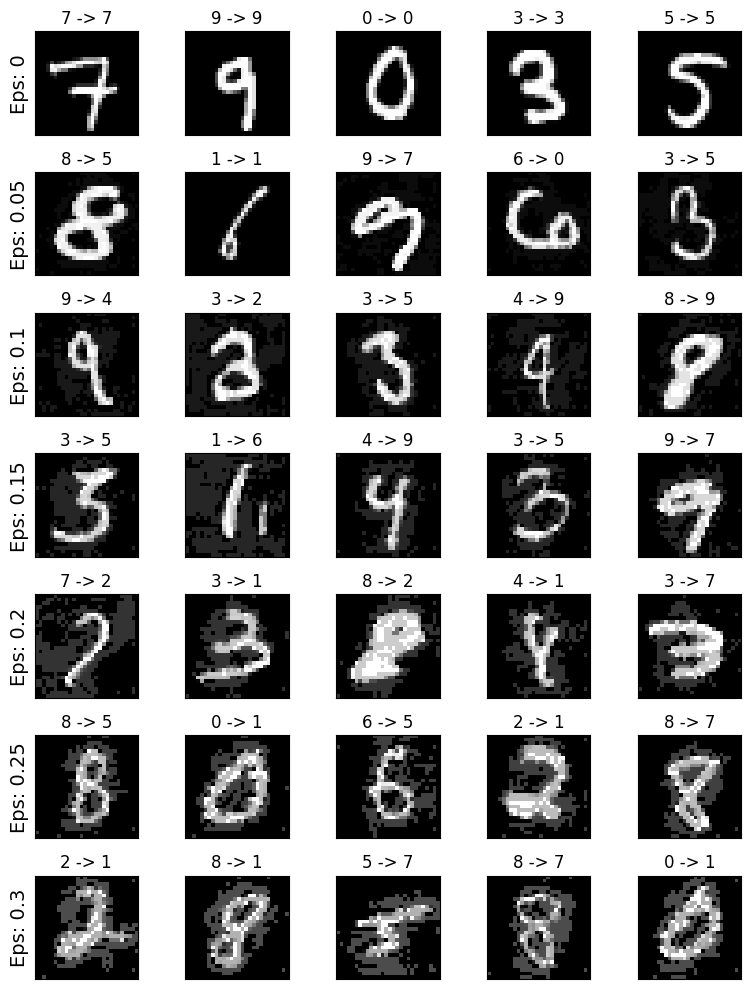

In [14]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(fgsm_epsilons)):
    for j in range(len(fgsm_examples[i])):
        cnt += 1
        plt.subplot(len(fgsm_epsilons),len(fgsm_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {fgsm_epsilons[i]}", fontsize=14)
        orig,adv,ex = fgsm_examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


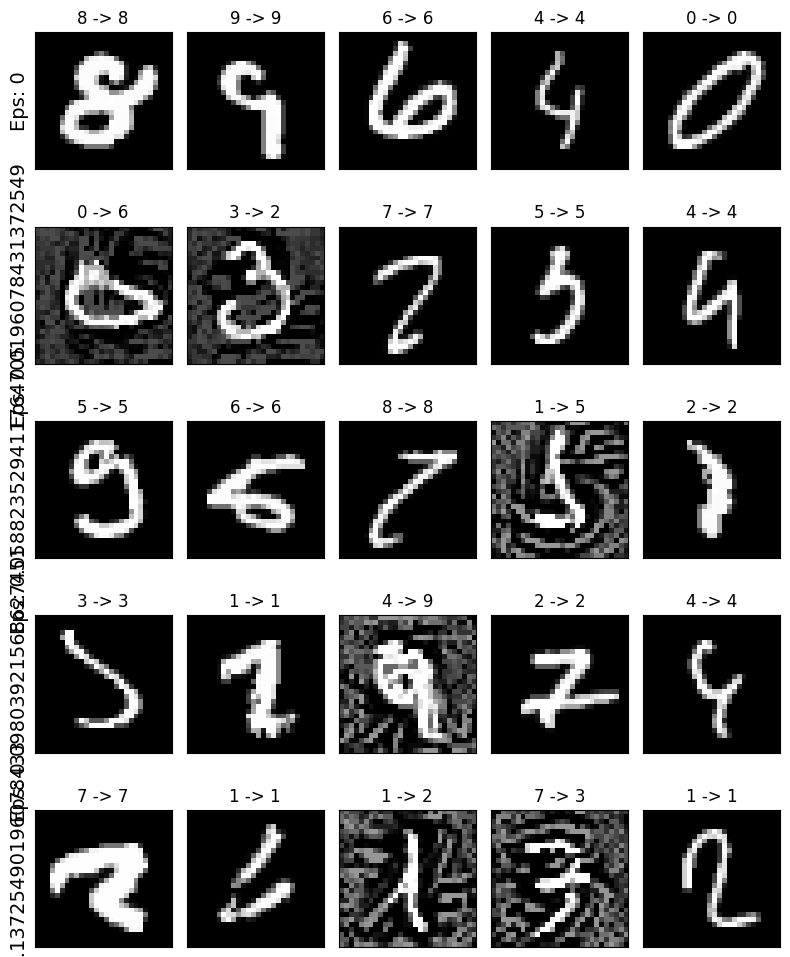

In [15]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(pgd_epsilons)):
    for j in range(len(pgd_examples[i])):
        cnt += 1
        plt.subplot(len(pgd_epsilons),len(pgd_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {pgd_epsilons[i]}", fontsize=14)
        orig,adv,ex = pgd_examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


In [16]:
aggr_data = []

for i in range(len(fgsm_accuracies)):
    data = []
    data.append("FGSM")
    data.append(fgsm_epsilons[i])
    data.append("NONE")
    data.append(fgsm_accuracies[i])
    aggr_data.append(data)


for i in range(len(pgd_accuracies)):
    data = []
    data.append("PGD")
    data.append(pgd_epsilons[i])
    data.append(alpha_param)
    data.append(pgd_accuracies[i])
    aggr_data.append(data)


print(tabulate(aggr_data, headers=['Type', 'Epsilon', 'Alpha', 'Accuracy']))


Type      Epsilon  Alpha                 Accuracy
------  ---------  ------------------  ----------
FGSM    0          NONE                     0.987
FGSM    0.05       NONE                     0.951
FGSM    0.1        NONE                     0.859
FGSM    0.15       NONE                     0.632
FGSM    0.2        NONE                     0.367
FGSM    0.25       NONE                     0.249
FGSM    0.3        NONE                     0.221
PGD     0          0.0392156862745098       0.993
PGD     0.0196078  0.0392156862745098       0.989
PGD     0.0588235  0.0392156862745098       0.987
PGD     0.0980392  0.0392156862745098       0.98
PGD     0.137255   0.0392156862745098       0.984


<H2>Discussion</H2>

PGD performs much better than FGSM, mostly because PGD allows more extreme perturbations with the given hyperparameter values. Note that the samples used to evaluate FGSM is not the same as the samples used to evaluate PGD, so the accuracies are not an apples to apples comparison. If alpha or epsilon was smaller, PGD might result similar accuracy to FGSM.